In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pylops
from pylops.utils.wavelets import ricker

plt.style.use('default')
np.random.seed(0)

/home/wwd/miniconda3/envs/pytorch1_13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
par = {"ox": 0, "dx": 1, "nx": 101, "ot": 0, "dt": 0.004, "nt": 500, "f0": 30}

# linear events
v = 1500  # m/s
t0 = [0.5, 0.8, 1.3]  # s
theta = [0, 0, 0]
amp = [1.0, 0.8, 0.5]

# parabolic event
tp0 = [1, 1.5]  # s
px = [0, 0]  # s/m
pxx = [5e-5, 3e-5]  # s²/m²
ampp = [0.2, 0.4]

# create axis
taxis, taxis2, xaxis, yaxis = pylops.utils.seismicevents.makeaxis(par)

# create wavelet
wav = ricker(taxis[:41], f0=par["f0"])[0]

# generate model
y = (
    pylops.utils.seismicevents.linear2d(xaxis, taxis, v, t0, theta, amp, wav)[1]
    + pylops.utils.seismicevents.parabolic2d(xaxis, taxis, tp0, px, pxx, ampp, wav)[1]
)

(np.float64(0.0), np.float64(100.0), np.float64(1.996), np.float64(0.0))

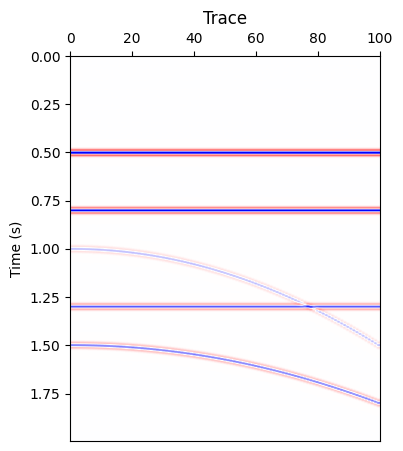

In [3]:
pclip = 0.7
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(4, 5))
axs.imshow(
    y.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(y).max(),
    vmax=pclip * np.abs(y).max(),
    extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]),
)
axs.set(ylabel="Time (s)", title="Trace")
axs.xaxis.set_ticks_position('top')
axs.xaxis.set_label_position('top')
axs.axis("tight")

In [10]:
nfft = int(2 ** np.ceil(np.log2(par["nt"])))
print(nfft)
npx, pxmax = 4 * par["nx"], 3e-3
px = np.linspace(-pxmax, pxmax, npx)

npx_para, pxmax_para = 8 * par["nx"], 1e-4
px_para = np.linspace(-pxmax_para, pxmax_para, npx_para)

R2Op_linear = pylops.signalprocessing.FourierRadon2D(
    taxis, xaxis, px, nfft, kind="linear", engine="numpy", dtype="float64"
)

R2Op_parabolic = pylops.signalprocessing.FourierRadon2D(
    taxis, xaxis, px_para, nfft, kind="parabolic", engine="numpy", dtype="float64"
)

R2Op_hyperbolic = pylops.signalprocessing.FourierRadon2D(
    taxis, xaxis, px, nfft, kind="hyperbolic", engine="numpy", dtype="float64"
)

px.size

512


404

In [11]:
dL_linear = R2Op_linear.H * y
dL_parabolic = R2Op_parabolic.H * y
dL_hyperbolic = R2Op_hyperbolic.H * y

dL_linear.shape

(404, 500)

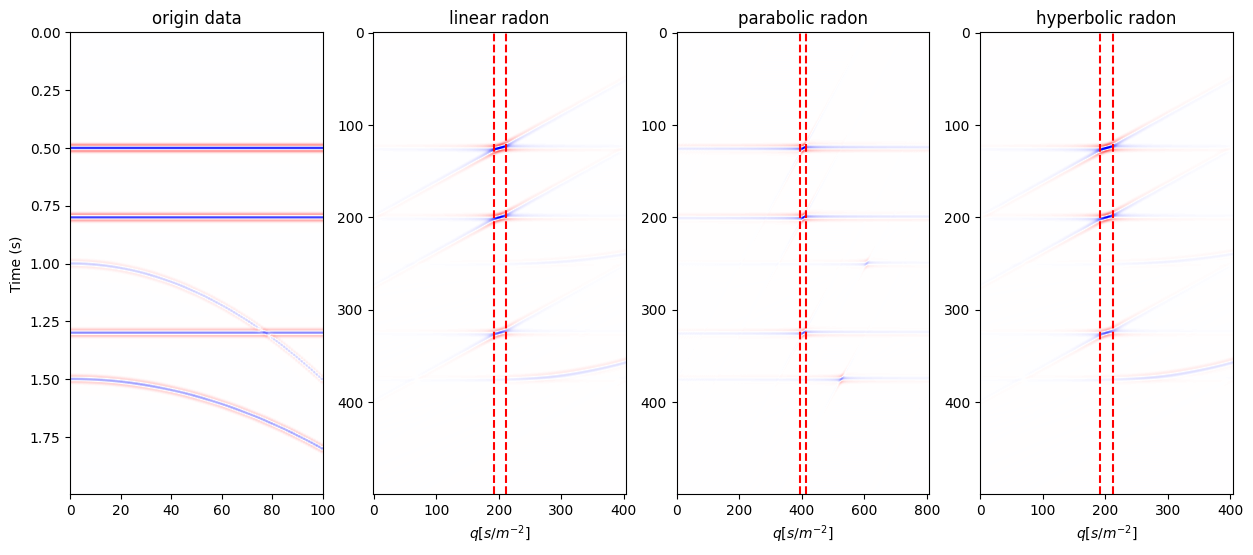

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

axs[0].imshow(y.T, vmin=-1, vmax=1, cmap="bwr_r", extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[0].set(ylabel=r"Time (s)", title="origin data")
axs[0].axis("tight")

axs[1].imshow(
    dL_linear.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_linear).max(),
    vmax=pclip * np.abs(dL_linear).max(),
)
axs[1].set(xlabel="$q [s/m^{-2}]$", title="linear radon")
axs[1].axis("tight")

axs[1].axvline(px.size//2 - 10, color="r", linestyle="--")
axs[1].axvline(px.size//2 + 10, color="r", linestyle="--")

axs[2].imshow(
    dL_parabolic.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_parabolic).max(),
    vmax=pclip * np.abs(dL_parabolic).max(),
)
axs[2].set(xlabel="$q [s/m^{-2}]$", title="parabolic radon")
axs[2].axis("tight")

axs[2].axvline(px_para.size//2 - 10, color="r", linestyle="--")
axs[2].axvline(px_para.size//2 + 10, color="r", linestyle="--")

axs[3].imshow(
    dL_hyperbolic.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_hyperbolic).max(),
    vmax=pclip * np.abs(dL_hyperbolic).max(),
)
axs[3].set(xlabel="$q [s/m^{-2}]$", title="hyperbolic radon")
axs[3].axis("tight")

axs[3].axvline(px.size//2 - 10, color="r", linestyle="--")
axs[3].axvline(px.size//2 + 10, color="r", linestyle="--")

In [13]:
dL_linear_filter = np.zeros_like(dL_linear)
dL_linear_filter[npx // 2 - 3 : npx // 2 + 3] = dL_linear[npx // 2 - 3 : npx // 2 + 3]

dL_parabolic_filter = np.zeros_like(dL_parabolic)
dL_parabolic_filter[npx_para // 2 - 5 : npx_para // 2 + 5] = dL_parabolic[npx_para // 2 - 5 : npx_para // 2 + 5]

dL_hyperbolic_filter = np.zeros_like(dL_hyperbolic)
dL_hyperbolic_filter[npx // 2 - 3 : npx // 2 + 3] = dL_hyperbolic[npx // 2 - 3 : npx // 2 + 3]

In [14]:
dL_linear_inverse = R2Op_linear * dL_linear_filter
dL_parabolic_inverse = R2Op_parabolic * dL_parabolic_filter
dL_hyperbolic_inverse = R2Op_hyperbolic * dL_hyperbolic_filter

dL_linear_inverse.shape

(101, 500)

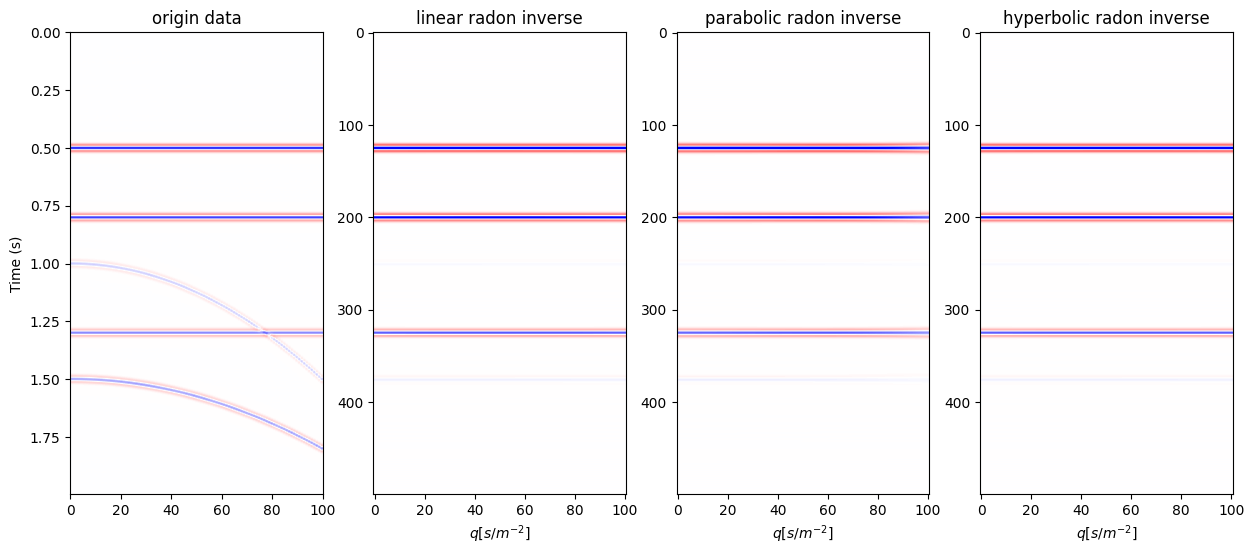

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

axs[0].imshow(y.T, vmin=-1, vmax=1, cmap="bwr_r", extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[0].set(ylabel=r"Time (s)", title="origin data")
axs[0].axis("tight")

axs[1].imshow(
    dL_linear_inverse.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_linear_inverse).max(),
    vmax=pclip * np.abs(dL_linear_inverse).max(),
)
axs[1].set(xlabel="$q [s/m^{-2}]$", title="linear radon inverse")
axs[1].axis("tight")

axs[1].axvline(px.size//2 - 10, color="r", linestyle="--")
axs[1].axvline(px.size//2 + 10, color="r", linestyle="--")

axs[2].imshow(
    dL_parabolic_inverse.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_parabolic_inverse).max(),
    vmax=pclip * np.abs(dL_parabolic_inverse).max(),
)
axs[2].set(xlabel="$q [s/m^{-2}]$", title="parabolic radon inverse")
axs[2].axis("tight")

axs[2].axvline(px.size//2 - 10, color="r", linestyle="--")
axs[2].axvline(px.size//2 + 10, color="r", linestyle="--")

axs[3].imshow(
    dL_hyperbolic_inverse.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_hyperbolic_inverse).max(),
    vmax=pclip * np.abs(dL_hyperbolic_inverse).max(),
)
axs[3].set(xlabel="$q [s/m^{-2}]$", title="hyperbolic radon inverse")
axs[3].axis("tight")

axs[3].axvline(px.size//2 - 10, color="r", linestyle="--")
axs[3].axvline(px.size//2 + 10, color="r", linestyle="--")